In [98]:
import librosa
import pandas as pd
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import csv
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from PIL import Image

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from keras.callbacks import CSVLogger

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Activation , Dropout, BatchNormalization

import IPython.display as ipd

In [32]:
path = '../input/urbansound8k/'

df = pd.read_csv('../input/urbansound8k/UrbanSound8K.csv')
#df

In [33]:
def features_extract(file):
    audio,sample_rate = librosa.load(file_name)
    feature = librosa.feature.mfcc(y=audio,sr=sample_rate,n_mfcc=50)
    scaled_feature = np.mean(feature.T,axis=0)
    return scaled_feature

extracted = []

for index_num,row in tqdm(df.iterrows()):
    file_name = os.path.join(os.path.abspath(path),'fold'+str(row["fold"])+'/',str(row['slice_file_name'])) 
    final_class_labels = row['class']   
    data= features_extract(file_name)    
    extracted.append([data,final_class_labels])

3553it [03:01, 19.31it/s]/opt/conda/lib/python3.10/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
8324it [06:40, 30.12it/s]/opt/conda/lib/python3.10/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(
8732it [06:58, 20.88it/s]


In [34]:
ext_df = pd.DataFrame(extracted,columns=['feature','class'])
ext_df

feature             class
0     [-211.93698, 62.58122, -122.813156, -60.745296...          dog_bark
1     [-417.00525, 99.336624, -42.995586, 51.073326,...  children_playing
2     [-452.39316, 112.36253, -37.578075, 43.195866,...  children_playing
3     [-406.47922, 91.19661, -25.043556, 42.784523, ...  children_playing
4     [-439.63873, 103.86224, -42.658787, 50.690285,...  children_playing
...                                                 ...               ...
8727  [-391.3721, 125.362404, -40.634056, 25.899755,...          car_horn
8728  [-339.42715, 76.4091, -35.309883, 41.98404, -2...          car_horn
8729  [-297.31534, 102.09027, -36.75108, 26.81649, -...          car_horn
8730  [-336.92386, 115.3139, -44.8471, 24.968985, -9...          car_horn
8731  [-307.41763, 83.30674, -25.756512, 35.44811, 4...          car_horn

[8732 rows x 2 columns]

In [35]:
x = np.array(ext_df['feature'].tolist())
y = np.array(ext_df['class'].tolist())

In [36]:
le = LabelEncoder()

y = to_categorical(le.fit_transform(y))

In [37]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state = 42)

print("Number of training samples = ", x_train.shape[0])
print("Number of testing samples = ",x_test.shape[0])

Number of training samples =  6985
Number of testing samples =  1747


In [38]:
num_labels = y.shape[1]
model = Sequential()

model.add(Dense(128, input_shape=(50,)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(128))

model.add(Dense(num_labels))
model.add(Activation('softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               6528      
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 128)               0         
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                        

In [39]:
def f1_score_metric(y_true, y_pred):
    y_pred_labels = tf.argmax(y_pred, axis=1)
    y_true_labels = tf.argmax(y_true, axis=1)
    y_pred_labels_np = tf.keras.backend.eval(y_pred_labels)
    y_true_labels_np = tf.keras.backend.eval(y_true_labels)
    f1 = f1_score(y_true_labels_np, y_pred_labels_np, average='weighted')
    return f1

In [40]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [45]:
class F1ScoreCallback(tf.keras.callbacks.Callback):
    def __init__(self, validation_data, csv_logger):
        super(F1ScoreCallback, self).__init__()
        self.validation_data = validation_data
        self.csv_logger = csv_logger

    def on_epoch_end(self, epoch, logs=None):
        x_val, y_val = self.validation_data
        y_pred = self.model.predict(x_val)
        f1 = f1_score_metric(y_val, y_pred)
        logs['val_f1'] = f1
        self.csv_logger.writerow(logs)
        print(f' - val_f1: {f1:.4f}')

### Logfile

In [46]:
# Define the path to the log file
log_file = 'training_log.csv'

# Create the CSVLogger callback
csv_logger = CSVLogger(log_file, separator=',', append=True)

In [47]:
with open('log.csv', 'w') as log_file:
    csv_logger = csv.DictWriter(log_file, fieldnames=['epoch', 'loss', 'accuracy', 'val_loss', 'val_accuracy', 'val_f1'])
    csv_logger.writeheader()

    callback = F1ScoreCallback(validation_data=(x_test, y_test), csv_logger=csv_logger)

    model.fit(
        x_train, 
        y_train, 
        batch_size=num_batch_size, 
        epochs=num_epochs,
        validation_data=(x_test, y_test),
        callbacks=[callback]
    )

Epoch 1/120
55/55 [==============================] - 0s 2ms/step loss: 1.6872 - accuracy: 0.
 - val_f1: 0.5852
219/219 [==============================] - 7s 9ms/step - loss: 1.6818 - accuracy: 0.4259 - val_loss: 1.1954 - val_accuracy: 0.5947 - val_f1: 0.5852
Epoch 2/120
55/55 [==============================] - 0s 2ms/step loss: 1.2970 - accuracy: 0.
 - val_f1: 0.6709
219/219 [==============================] - 1s 7ms/step - loss: 1.2972 - accuracy: 0.5548 - val_loss: 1.0104 - val_accuracy: 0.6783 - val_f1: 0.6709
Epoch 3/120
55/55 [==============================] - 0s 2ms/step loss: 1.1350 - accuracy: 0.
 - val_f1: 0.7159
219/219 [==============================] - 2s 7ms/step - loss: 1.1341 - accuracy: 0.6157 - val_loss: 0.8593 - val_accuracy: 0.7224 - val_f1: 0.7159
Epoch 4/120
55/55 [==============================] - 0s 2ms/step loss: 0.9940 - accuracy: 0.
 - val_f1: 0.7480
219/219 [==============================] - 1s 7ms/step - loss: 0.9961 - accuracy: 0.6636 - val_loss: 0.7671 - va

In [48]:
# Save the trained model
model.save('trained_audio_model.h5')

In [100]:
def extract_feature(file_name):
    audio_data, sample_rate = librosa.load(file_name) 
    fea = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=50)
    scaled = np.mean(fea.T,axis=0)
    return np.array([scaled])

In [101]:
def print_prediction(file_name):
    pred_fea = extract_feature(file_name) 
    pred_vector = np.argmax(model.predict(pred_fea), axis=-1)
    pred_class = le.inverse_transform(pred_vector)
    print("The predicted class is:", pred_class[0], '\n') 

In [102]:
file_name = '../input/urbansound8k/fold2/100652-3-0-2.wav'

print_prediction(file_name)

ipd.Audio(file_name)

1/1 [==============================] - 0s 48ms/step
The predicted class is: dog_bark 



In [122]:
watermark_img = Image.open('/kaggle/input/fraunhofer-png/exhibitor-A000115486-290852021-1628155373.png')

aspect_ratio = watermark_img.width / watermark_img.height
new_width = 0.6 * plt.gcf().get_figwidth()
new_height = new_width / aspect_ratio
print(watermark_img.width, watermark_img.height, aspect_ratio, (new_width), new_height)

1080 294 3.673469387755102 3.84 1.0453333333333332


<Figure size 640x480 with 0 Axes>

## Plotting Accuracy and F1

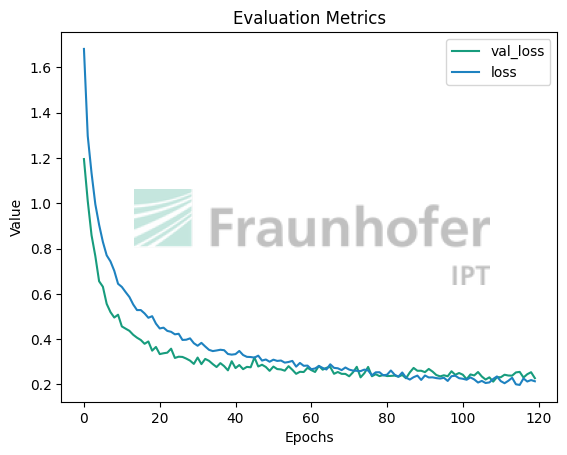

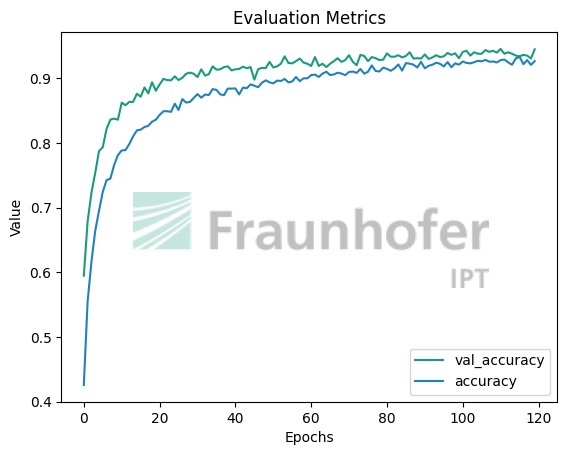

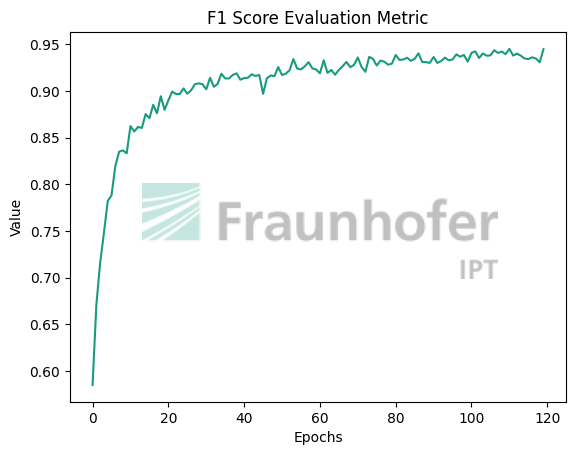

In [154]:
# Get the desired data from the CSV file
filename = '/kaggle/working/log.csv'
df       = pd.read_csv(filename)

epochs   = np.linspace(0,119,120)
loss     = df.iloc[:,1]
accuracy = df.iloc[:,2]
val_loss = df.iloc[:,3]
val_accuracy = df.iloc[:,4]
f1_eval  = df.iloc[:,5]
names = ['loss', 'val_loss', 'accuracy', 'val_accuracy', 'f1_label']

#Colors and Background
watermark_img = Image.open('/kaggle/input/fraunhofer-png/exhibitor-A000115486-290852021-1628155373.png')

aspect_ratio = watermark_img.width / watermark_img.height
new_width = 40 * plt.gcf().get_figwidth()  # Adjust the scaling factor (0.2) as needed
new_height = new_width / aspect_ratio
watermark_img = watermark_img.resize((int(new_width), int(new_height)), Image.LANCZOS)


green_ipt = ['#179C7D']
blue_ipt = ['#1E82C0']

#Plotting

def plot_values(yaxis1,yaxis2, leg1, leg2, height, xaxis=epochs):    
    plt.plot(xaxis, yaxis1, '#179C7D')
    plt.plot(xaxis, yaxis2, '#1E82C0')
    plt.title('Evaluation Metrics')
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.legend([f'{leg1}', f'{leg2}'])
    
    imagebox = OffsetImage(watermark_img, alpha=0.25)
    ab = AnnotationBbox(imagebox, (60,height), frameon=False)
    plt.gca().add_artist(ab)
    
    plt.show()

def plot_single(yaxis1, height, xaxis=epochs):
    plt.plot(xaxis, yaxis1, '#179C7D')
    plt.title('F1 Score Evaluation Metric')
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    
    imagebox = OffsetImage(watermark_img, alpha=0.25)
    ab = AnnotationBbox(imagebox, (60,height), frameon=False)
    plt.gca().add_artist(ab)
    
    plt.show()

    
#Loss Plot
plot_values(val_loss, loss, names[1], names[0],0.85)
#Accuracy Plot
plot_values(val_accuracy, accuracy, names[3], names[2],0.65)
#F1 Score Plot
plot_single(f1_eval, 0.75)


In [14]:
file_name = '../input/urbansound8k/fold6/101281-3-0-14.wav'

print_prediction(file_name)

ipd.Audio(file_name)

The predicted class is: dog_bark 



In [18]:
file_name = '../input/urbansound8k/fold7/102853-8-0-2.wav'

print_prediction(file_name)

ipd.Audio(file_name)

The predicted class is: siren 



In [19]:
file_name = '/kaggle/input/urbansound8k/fold3/103199-4-2-3.wav'

print_prediction(file_name)

ipd.Audio(file_name)

The predicted class is: drilling 



In [22]:
file_name = '/kaggle/input/urbansound8k/fold5/100852-0-0-1.wav'

print_prediction(file_name)

ipd.Audio(file_name)

The predicted class is: air_conditioner 



In [25]:
file_name = '/kaggle/input/recorder/air_conditioner.wav'

print_prediction(file_name)

ipd.Audio(file_name)

The predicted class is: children_playing 



## Saving the model

In [23]:
model.save('audio_model_v1.h5')